In [10]:
from collections import defaultdict
import numpy as np
from itertools import product
from scipy.special import gamma
from scipy.spatial.distance import pdist, squareform, euclidean
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from sklearn.linear_model import LinearRegression
import math
from functions_for_clustering import *
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn import metrics

In [11]:
df = pd.read_csv('data/test/part_1.csv')
df.head(-1)

,Ticker,index,Date,extremum,-1,-2,-3,-4,-5,-6,...,-275,-276,-277,-278,-279,-280,-281,-282,-283,-284
0,1KN.F,20.0,2020-03-19,0.0,0.096982,0.080357,0.302031,0.290947,0.451661,0.534789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1KN.F,295.0,2021-04-22,1.0,0.933649,0.970444,0.930030,0.908918,0.876949,0.907711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1KR.F,22.0,2020-03-23,0.0,0.156874,0.052010,0.133618,0.098099,0.026216,0.181822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1KR.F,284.0,2021-04-07,1.0,0.947131,0.897271,0.931228,0.896841,0.901139,0.931228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1KR.SG,134.0,2020-09-01,0.0,0.025797,0.065625,0.076034,0.085539,0.109978,0.087349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11145,CADDKK=X,0.0,2020-02-20,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11146,CADDKK=X,116.0,2020-07-31,0.0,0.109641,0.131751,0.120152,0.156760,0.207865,0.219827,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11147,CADE,31.0,2020-04-03,0.0,0.045611,0.059295,0.090209,0.096798,0.114535,0.107440,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11148,CADE,267.0,2021-03-12,1.0,0.975990,0.944672,0.884125,0.888823,0.871598,0.846022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#extracting data
df_temp = df.drop(labels=['Ticker', 'index', 'Date', 'extremum'], axis=1)

key1 = -15
key2 = min([int(x) for x in df_temp.columns])

df_temp = df_temp.drop(labels=[str(x) for x in list(range(key2,key1))], axis=1)
df_temp = df_temp.loc[df_temp.index < 11150]  #тут было 4000 (ну так, чисто на всякий)
df_temp = df_temp.dropna(axis=0)

clustering_data_trended = df_temp.values.tolist()
clustering_data = detrend(clustering_data_trended)


In [13]:
def generate_z_vector_best_new_VERY_BEST(arr, n):
    z_vector = []
    partition = (len(arr)) // n
    for i in range(0,len(arr),partition):
        a = index_element(arr, i, partition, "max")
        b = index_element(arr, i, partition, "min")
        a, b = min(a, b), max(a, b)
        z_vector.append(arr[a])
        z_vector.append(arr[b])
    return z_vector


def make_z_vector_fixed(arr, pattern):
    z_vector = []
    for i in range(len(pattern)):
        z_vector.append(arr[pattern[i]])
    return z_vector

In [15]:
#creating z-functions for everything
clustering_data_z_optimized = []
for i in clustering_data:
    clustering_data_z_optimized.append(make_z_vector_fixed(i, [0, 2, 4, 8, 14]))
# print(clustering_data_z_optimized)

In [16]:
clustering_result = get_clustering(clustering_data_z_optimized, 2, 1)
clustering_result

C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  p = [k / (volume(dk[i], m) * n) for i in range(n)]
C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:18: RuntimeWarning: invalid value encountered in double_scalars
  max_diff = max(abs(p[i] - p[j]) for i, j in product(cluster, cluster))


array([2216,  633, 2092, ..., 1285, 2215, 1356])

In [17]:
sns.set(rc={'figure.figsize':(20,7)})

visualization_data = []
for i in range(len(clustering_result)):
    if clustering_result[i] == max(set(clustering_result), key=list(clustering_result).count):
        visualization_data.append(clustering_data[i])

visualization_index = list(range(len(clustering_data[0])))
for i in visualization_data:
    sns.lineplot(y=i, x=visualization_index)

KeyboardInterrupt: 

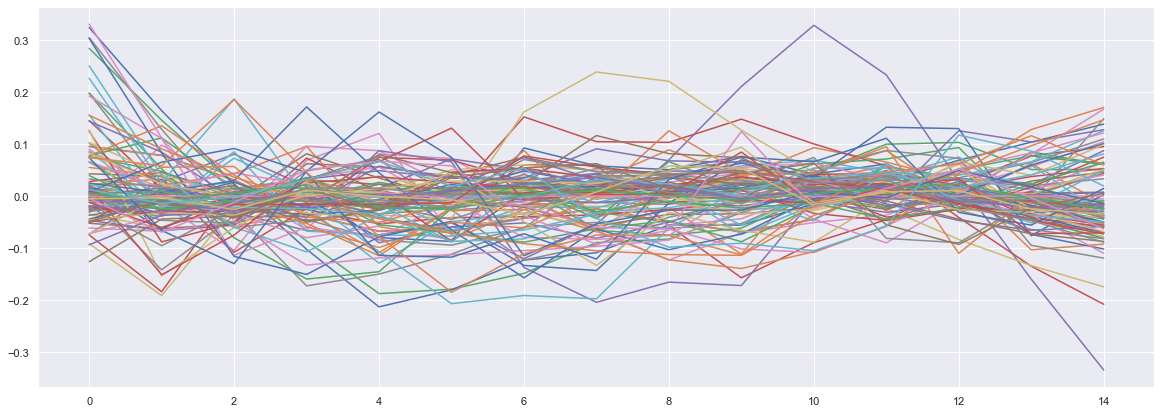

In [14]:
visualization_data = []
for i in range(len(clustering_result)):
    visualization_data.append(clustering_data[i])
    
visualization_index = list(range(len(clustering_data[0])))
for i in visualization_data:
    sns.lineplot(y=i, x=visualization_index)

<AxesSubplot:>

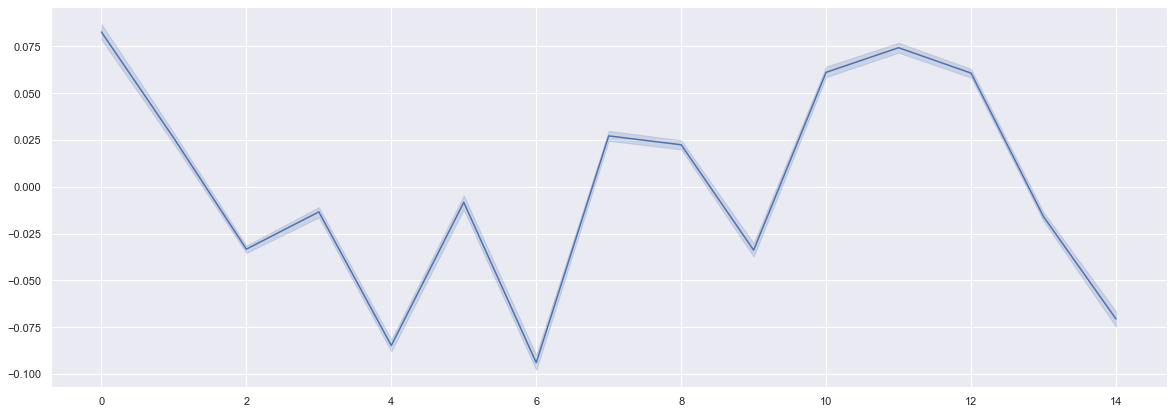

In [42]:
visualization_data_temp = []
for i in range(len(clustering_result)):
    if clustering_result[i] == max(set(clustering_result), key=list(clustering_result).count):
        visualization_data_temp.append(clustering_data[i])

visualization_data_flat = np.array(visualization_data_temp).flatten()        
visualization_index_flat = np.array(list(range(len(clustering_data[0])))*len(visualization_data_temp)).flatten()


sns.lineplot(y=visualization_data_flat, x=visualization_index_flat)

<AxesSubplot:>

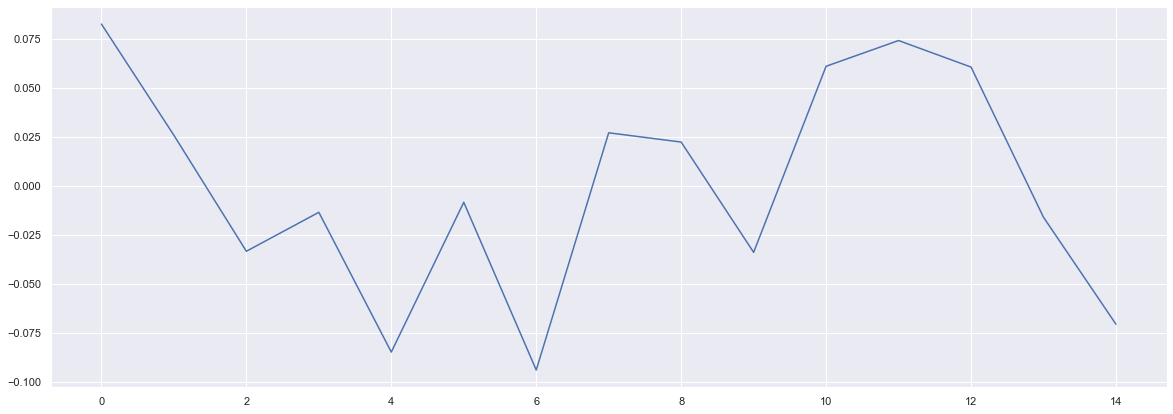

In [66]:
visualization_data = []
for i in range(len(clustering_result)):
    if clustering_result[i] == max(set(clustering_result), key=list(clustering_result).count):
        visualization_data.append(clustering_data[i])
        
visualization_index = list(range(len(clustering_data[0])))
    
motif = generate_motif(visualization_data)

sns.lineplot(y=motif, x=visualization_index)

In [13]:
visualization_data = []
for i in range(len(clustering_result)):
    if clustering_result[i] == max(set(clustering_result), key=list(clustering_result).count):
        visualization_data.append(clustering_data[i])
        
neighborhood = []
visualization_index = list(range(len(clustering_data[0])))
visualization_data_flat = np.array(visualization_data).flatten()
visualization_index_flat = np.array(list(range(len(clustering_data[0])))*len(visualization_data)).flatten()
for i in visualization_index:
    neighborhood.append(find_boundaries(visualization_data, visualization_data_flat, i))
neighborhood = np.transpose(neighborhood)
motif2 = [(neighborhood[0][x]+neighborhood[1][x])/2 for x in list(range(len(neighborhood[1])))]
sns.lineplot(y=neighborhood[0], x=visualization_index)
sns.lineplot(y=neighborhood[1], x=visualization_index)
sns.lineplot(y=motif2, x=visualization_index)

KeyboardInterrupt: 

In [12]:
def find_boundaries(visualization_data, visualization_data_flat, time_stamp):
    distance = max(visualization_data_flat) - min(visualization_data_flat)
    #distance2 = math.hypot(max(motif), min(motif))
    #distance3 = abs(max(motif))*math.sqrt(1 + (min(motif)/max(motif))**2)
    scale = np.arange(min(visualization_data_flat),max(visualization_data_flat), distance/100)

    count_on_scale = [0]*len(scale)
    for scale_range_index in range(len(scale)-1):
        for time_series in visualization_data:
            if scale[scale_range_index] < time_series[time_stamp] < scale[scale_range_index + 1]:
                count_on_scale[scale_range_index] += 1

    for i in range(len(count_on_scale)):
        if count_on_scale[i] <= 0.65*max(count_on_scale):
            count_on_scale[i] = 0

    boundaries = []
    index_max = count_on_scale.index(max(count_on_scale))
    for i in range(index_max, 0, -1):
        if count_on_scale[i] == 0:
            boundaries.append(scale[i])
            break
    for i in range(index_max, len(count_on_scale)):
        if count_on_scale[i] == 0:
            boundaries.append(scale[i])
            break
    return boundaries

## Clustering validation starts in 3... 2... 1...

In [14]:
labels = list(clustering_result)
X = clustering_data_z_optimized

print(metrics.silhouette_score(X, labels, metric='euclidean'))
print(metrics.davies_bouldin_score(X, labels))

-0.2556691339832158
4.378465160689993


## Сюда будем записывать результаты кластеризации

| Версия z-vector | Кол-во элементов в кластеризации | Silhouette score | Davies - Bouldin (DB) score|Вердикт |
| :-: | :-: | :-: | :-:| :-: | 
| Старая (min/max) | 4000 | -0.335068 | - | quite a lot of samples (series) have been assigned to wrong clusters | 
| Новая (min - max) (среднее) | 4000 | -0.19188 | - |Уже получше, но все равно отрицательные числа, а это плохо | 
| Новая (min - max) (на каждом участке выбираем min max) | 4000 | -0.05820 | - |Уже получше, но все равно отрицательные числа, а это плохо, а тут еще и близко к 0 |
|Новая (min - max) (на каждом участке выбираем min max) | 10000 | 0.06038 | 1.62692 | Есть небольшой прогресс, но желательно увеличить Silhouette score |
|Новая (min - max) (на каждом участке выбираем min max) | 11150 | 0.0347 | 1.6605 | А вот уже хуже результат => проблема заключается не в количестве данных в сете => выбираем новый z-vector |
|Фиксированный (pattern [0, 2, 4, 8, 14])| 11150 | -0.0825 | 2.24505 | Паттерн не подохдит |
| Паттерн [0,3,5,7,12] | 11150 | -0.10492682844978846 | 2.470385184226473 | тут вердикт |
| Паттерн [1,4,8,10,11] | 11150 | -0.09749746413444833 | 2.399412641638247 | тут вердикт |
| Паттерн [2,6,8,9,13] | 11150 | -0.10686420210405081 | 2.4788505099832765 | тут вердикт |
| Паттерн [0,4,10,11,14] | 11150 | -0.08174832884937858 | 2.2650924938340107 | тут вердикт |
| Паттерн [0,6,10,11,12] | 11150 | -0.10624902163889588 | 2.420252042798195 | тут вердикт |
| Паттерн [8,10,12,13,14] | 11150 | -0.10067361565230795 | 2.4912638696601865 | тут вердикт |
| Паттерн [3,7,8,9,12] | 11150 | -0.11449582245579311 | 2.4841137795391552 | тут вердикт |
| Паттерн [0,6,8,9,14] | 11150 | -0.04597733773466437 | 2.0713645257828137 | тут вердикт |
| Паттерн [0,1,3,10,12] | 11150 | -0.08140103358517538 | 2.28239509614075 | тут вердикт |
| Паттерн [0,3,7,10,13] | 11150 | -0.1078494258934735 | 2.449530730132603 | тут вердикт |
| Паттерн [1,5,7,10,11] | 11150 | -0.10159544254177431 | 2.495735008008683 | тут вердикт |
| Паттерн [0,2,7,9,13] | 11150 | -0.09610445821242079 | 2.3665140844205044 | тут вердикт |

# Правильная таблица для z_vector

| Паттерн z-vector | Кол-во элементов в кластеризации | Silhouette score | Davies - Bouldin (DB) score|Вердикт |
| :-: | :-: | :-: | :-:| :-: |
| Паттерн [0,3,5,7,12] | 11150 | 0.19284020800009968 | 1.1021019887701886 | тут вердикт |
| Паттерн [1,4,8,10,11] | 11150 | 0.18753129764444396 | 1.1157028504833209 | тут вердикт |
| Паттерн [2,6,8,9,13] | 11150 | 0.18714132273566295 | 1.1144863006286747 | тут вердикт |
| **Паттерн [0,4,10,11,14]** | 11150 | 0.2022315319082082 | 1.089206868110845 | тут вердикт |
| Паттерн [0,6,10,11,12] | 11150 | 0.19095277029274574 | 1.1356167639282246 | тут вердикт |
| Паттерн [8,10,12,13,14] | 11150 | 0.18079348559215314 | 1.1446381875351732 | тут вердикт |
| Паттерн [3,7,8,9,12] | 11150 | 0.1927368128600975 | 1.1152937233654605 | тут вердикт |
| Паттерн [0,6,8,9,14] | 11150 | 0.19081498611567127 | 1.1218044597151595 | тут вердикт |
| Паттерн [0,1,3,10,12] | 11150 | 0.1895995807683512 | 1.137651048786514 | тут вердикт |
| Паттерн [0,3,7,10,13] | 11150 | 0.18648733954574565 | 1.1251524861025624 | тут вердикт |
| Паттерн [1,5,7,10,11] | 11150 | 0.18211931590335273 | 1.1313499682618988 | тут вердикт |
| **Паттерн [0,2,7,9,13]** | 11150 | 0.1938976112768608 | 1.1002875655493267 | тут вердикт |
| [3, 7, 9, 13, 14] | 11150 | 0.18412323979420755  |  1.1037160745181653  |  Вердикт |
| [0, 4, 9, 11, 12] | 11150 | 0.19586320707132043  |  1.1117432204361428  |  Вердикт |
| [0, 4, 7, 11, 13] | 11150 | 0.19554529148465147  |  1.1111993455189255  |  Вердикт |
| [0, 3, 8, 11, 13] | 11150 | 0.1908915534129633  |  1.0879445722972745  |  Вердикт |
| [2, 9, 10, 12, 14] | 11150 | 0.19083858141149096  |  1.1059755181430577  |  Вердикт |
| [1, 3, 5, 7, 14] | 11150 | 0.1868617252846693  |  1.11839842531484  |  Вердикт |
| [2, 4, 5, 10, 14] | 11150 | 0.19547381679846385  |  1.0937084709049407  |  Вердикт |
| [2, 4, 7, 9, 11] | 11150 | 0.18420045226930062  |  1.12487201404646  |  Вердикт |
| [3, 4, 8, 10, 12] | 11150 | 0.1910549152001123  |  1.0973149406263407  |  Вердикт |
| [0, 1, 3, 7, 14] | 11150 | 0.19638442204471954  |  1.0983503968144896  |  Вердикт |
| [0, 1, 6, 7, 14] | 11150 | 0.20050933697506512  |  1.0878738256484874  |  Вердикт |
| [4, 5, 7, 12, 14] | 11150 | 0.19580142420231664  |  1.1026059760549138  |  Вердикт |
| [1, 2, 4, 7, 14] | 11150 | 0.19392345797254232  |  1.1177107555284944  |  Вердикт |
| [1, 2, 8, 9, 10] | 11150 | 0.1881088828623167  |  1.1280320730557227  |  Вердикт |
| [3, 10, 12, 13, 14] | 11150 | 0.1885576983709882  |  1.1026615028682627  |  Вердикт |
| [0, 5, 7, 10, 12] | 11150 | 0.1979604029712673  |  1.1017705580368566  |  Вердикт |
| [1, 3, 7, 8, 10] | 11150 | 0.18929712407376875  |  1.1042593297566965  |  Вердикт |
| [3, 10, 11, 12, 13] | 11150 | 0.19044996820365173  |  1.1149472601229695  |  Вердикт |
| [0, 2, 3, 6, 14] | 11150 | 0.1933559455674567  |  1.102721642523788  |  Вердикт |
| [0, 1, 2, 6, 13] | 11150 | 0.1886271377785178  |  1.1710370715811536  |  Вердикт |
| [0, 1, 2, 4, 14] | 11150 | 0.19938620988422942  |  1.1048642595549518  |  Вердикт |
| [0, 5, 8, 10, 13] | 11150 | 0.1949666626764276  |  1.1169720794849385  |  Вердикт |
| [2, 5, 6, 11, 12] | 11150 | 0.19033872873340374  |  1.1200692249846436  |  Вердикт |
| [2, 4, 9, 12, 14] | 11150 | 0.1909349441919493  |  1.0868263167485552  |  Вердикт |
| [0, 5, 8, 12, 13] | 11150 | 0.19454371820322888  |  1.1755522673369283  |  Вердикт |
| [0, 9, 11, 13, 14] | 11150 | 0.19249263669032626  |  1.0984091017615225  |  Вердикт |
| [1, 3, 6, 8, 11] | 11150 | 0.19144871565614055  |  1.0934418673890591  |  Вердикт |
| [1, 5, 7, 10, 12] | 11150 | 0.19516572998471193  |  1.1108063835334148  |  Вердикт |
| [0, 6, 7, 10, 11] | 11150 | 0.19686569885006663  |  1.1083021409639353  |  Вердикт |
| [0, 2, 4, 6, 11] | 11150 | 0.19377310607638543  |  1.105094523414602  |  Вердикт |
| [3, 4, 10, 11, 12] | 11150 | 0.18462910923825995  |  1.112856092596373  |  Вердикт |
| [0, 6, 7, 10, 14] | 11150 | 0.19459143291735806  |  1.0922569094894587  |  Вердикт |
| [0, 3, 9, 11, 14] | 11150 | 0.19113040138160872  |  1.106285627351521  |  Вердикт |
| [2, 5, 6, 8, 12] | 11150 | 0.18962586665346148  |  1.1346092635225464  |  Вердикт |
| [2, 4, 5, 9, 11] | 11150 | 0.19433431058243059  |  1.11010258206395  |  Вердикт |
| [3, 6, 8, 9, 14] | 11150 | 0.19214956633664282  |  1.1265375062437997  |  Вердикт |
| [0, 1, 3, 7, 14] | 11150 | 0.19638442204471954  |  1.0983503968144896  |  Вердикт |
| [0, 5, 6, 8, 10] | 11150 | 0.20134887894586853  |  1.0818400047389924  |  Вердикт |
| [1, 5, 6, 7, 13] | 11150 | 0.19023272512066433  |  1.1087505669610986  |  Вердикт |
| [0, 9, 10, 11, 14] | 11150 | 0.19262018831872707  |  1.1159319213014143  |  Вердикт |
| [0, 2, 7, 11, 14] | 11150 | 0.19416203208713187  |  1.1083777830059514  |  Вердикт |
| [0, 5, 8, 10, 14] | 11150 | 0.19824181321902143  |  1.103691204334271  |  Вердикт |
| [2, 3, 5, 10, 12] | 11150 | 0.19107100936993346  |  1.104341930330678  |  Вердикт |
| [2, 4, 7, 12, 14] | 11150 | 0.19315318796012484  |  1.106275096277325  |  Вердикт |
| [1, 3, 6, 10, 11] | 11150 | 0.19020910961814552  |  1.1048188064041458  |  Вердикт |
| [1, 2, 3, 12, 14] | 11150 | 0.19088553388103432  |  1.1306553205518333  |  Вердикт |
| [1, 2, 3, 6, 12] | 11150 | 0.18859232685790828  |  1.1194409831451686  |  Вердикт |
| [1, 2, 6, 11, 12] | 11150 | 0.19218870888581738  |  1.1084679974282934  |  Вердикт |
| [1, 5, 6, 12, 14] | 11150 | 0.18612690786058703  |  1.1168341237112114  |  Вердикт |
| [3, 5, 8, 10, 13] | 11150 | 0.19117689270259486  |  1.1164394302801919  |  Вердикт |
| [2, 4, 5, 7, 8] | 11150 | 0.19481230174431743  |  1.087913915980661  |  Вердикт |
| [0, 7, 12, 13, 14] | 11150 | 0.19481912604090998  |  1.0783901823743114  |  Вердикт |
| [1, 6, 7, 8, 9] | 11150 | 0.19008505749787916  |  1.1041231598021246  |  Вердикт |
| [1, 6, 7, 10, 11] | 11150 | 0.18632783284356036  |  1.1161280893792715  |  Вердикт |
| [1, 3, 8, 10, 11] | 11150 | 0.19031506855059752  |  1.109227636576931  |  Вердикт |
| [1, 2, 5, 11, 12] | 11150 | 0.1924065295188852  |  1.1061419114498552  |  Вердикт |
| [1, 4, 5, 12, 13] | 11150 | 0.193365603557158  |  1.1431832880979491  |  Вердикт |
| [0, 6, 7, 9, 12] | 11150 | 0.19877968868372783  |  1.0896524200343463  |  Вердикт |
| [1, 4, 6, 12, 14] | 11150 | 0.19320529679165444  |  1.1175756640741752  |  Вердикт |
| [0, 1, 2, 8, 12] | 11150 | 0.19430201970443206  |  1.134908163800652  |  Вердикт |
| [3, 4, 5, 9, 11] | 11150 | 0.1912082106802387  |  1.1440592135212944  |  Вердикт |
| [4, 5, 8, 10, 13] | 11150 | 0.18808493873445897  |  1.1197236835099795  |  Вердикт |
| [1, 2, 8, 9, 11] | 11150 | 0.18572523490968987  |  1.154965204685947  |  Вердикт |
| [2, 3, 4, 6, 12] | 11150 | 0.19584879880531506  |  1.0886082952857377  |  Вердикт |
| [6, 9, 12, 13, 14] | 11150 | 0.1980899644793027  |  1.1205214970655728  |  Вердикт |
| [2, 3, 5, 6, 14] | 11150 | 0.19605432938734532  |  1.1078367821654114  |  Вердикт |
| [1, 5, 8, 10, 11] | 11150 | 0.18879110340873895  |  1.120131737605917  |  Вердикт |
| [1, 4, 10, 11, 14] | 11150 | 0.19129608971327977  |  1.1096063157526304  |  Вердикт |
| [7, 8, 9, 10, 12] | 11150 | 0.18466561672585624  |  1.1332441273865768  |  Вердикт |
| [2, 4, 5, 6, 13] | 11150 | 0.1930218832219267  |  1.1239280011668402  |  Вердикт |
| [2, 4, 6, 8, 12] | 11150 | 0.1967857430510867  |  1.086376858971703  |  Вердикт |
| [4, 5, 6, 8, 14] | 11150 | 0.19002302731815526  |  1.1010001293947667  |  Вердикт |
| [4, 6, 7, 8, 10] | 11150 | 0.18604951513046178  |  1.1162279518550249  |  Вердикт |
| [0, 1, 7, 12, 14] | 11150 | 0.19788113210811503  |  1.0961847366992148  |  Вердикт |
| [1, 2, 7, 9, 13] | 11150 | 0.1871541808772475  |  1.1380192848759711  |  Вердикт |
| [0, 5, 8, 9, 10] | 11150 | 0.19672897257237895  |  1.1029209267120421  |  Вердикт |
| [0, 1, 7, 8, 11] | 11150 | 0.18851980675411809  |  1.1139409793719555  |  Вердикт |
| [4, 5, 6, 9, 13] | 11150 | 0.19040901880541697  |  1.1027464642193396  |  Вердикт |
| [0, 1, 3, 12, 13] | 11150 | 0.1877845976861944  |  1.1158656019883633  |  Вердикт |
| [1, 3, 6, 10, 12] | 11150 | 0.18633938510545592  |  1.1237490884870223  |  Вердикт |
| [1, 2, 3, 8, 13] | 11150 | 0.18294805315127327  |  1.1068588326838715  |  Вердикт |
| [0, 4, 7, 9, 14] | 11150 | 0.20419908186419336  |  1.0863488073736869  |  Вердикт |
| [1, 2, 5, 9, 10] | 11150 | 0.19616048078070575  |  1.1306384805360143  |  Вердикт |
| [4, 7, 9, 11, 13] | 11150 | 0.19671243207054323  |  1.1168198342917754  |  Вердикт |
| [0, 4, 9, 12, 13] | 11150 | 0.18884668800156154  |  1.14426488857532  |  Вердикт |
| [4, 11, 12, 13, 14] | 11150 | 0.19280664692049881  |  1.110883897518418  |  Вердикт |

In [18]:
array_of_patterns = []

In [27]:
f = open("patterns/best_patterns.txt", 'r')

for line in f:
    temp1 = list(map(str, line.split()))
#     temp = list(map(int, new_line.split(", ")))
#     array_of_patterns.append(temp)
    pat = [int(temp1[0][:-1]), int(temp1[1][:-1]), int(temp1[2][:-1]), int(temp1[3][:-1]), int(temp1[4])]
    array_of_patterns.append(pat)
        
print(array_of_patterns)
f.close()

[[0, 3, 5, 7, 12], [0, 4, 10, 11, 14], [0, 2, 7, 9, 13], [3, 7, 9, 13, 14], [0, 3, 8, 11, 13], [2, 9, 10, 12, 14], [2, 4, 5, 10, 14], [3, 4, 8, 10, 12], [0, 1, 3, 7, 14], [0, 1, 6, 7, 14], [4, 5, 7, 12, 14], [3, 10, 12, 13, 14], [0, 5, 7, 10, 12], [1, 3, 7, 8, 10], [0, 2, 3, 6, 14], [0, 1, 2, 4, 14], [2, 4, 9, 12, 14], [0, 9, 11, 13, 14], [1, 3, 6, 8, 11], [0, 6, 7, 10, 11], [0, 2, 4, 6, 11], [0, 6, 7, 10, 14], [0, 3, 9, 11, 14], [0, 1, 3, 7, 14], [0, 5, 6, 8, 10], [1, 5, 6, 7, 13], [0, 2, 7, 11, 14], [0, 5, 8, 10, 14], [2, 3, 5, 10, 12], [2, 4, 7, 12, 14], [1, 3, 6, 10, 11], [1, 2, 6, 11, 12], [2, 4, 5, 7, 8], [0, 7, 12, 13, 14], [1, 6, 7, 8, 9], [1, 3, 8, 10, 11], [1, 2, 5, 11, 12], [0, 6, 7, 9, 12], [2, 3, 4, 6, 12], [6, 9, 12, 13, 14], [2, 3, 5, 6, 14], [1, 4, 10, 11, 14], [2, 4, 6, 8, 12], [4, 5, 6, 8, 14], [0, 1, 7, 12, 14], [0, 5, 8, 9, 10], [4, 5, 6, 9, 13], [1, 2, 3, 8, 13], [0, 4, 7, 9, 14], [1, 2, 5, 9, 10], [4, 7, 9, 11, 13]]


In [28]:
import timeit

start = timeit.default_timer()

array_of_patterns = [[0, 3, 5, 7, 12], [0, 4, 10, 11, 14], [0, 2, 7, 9, 13], [3, 7, 9, 13, 14], [0, 3, 8, 11, 13], [2, 9, 10, 12, 14], [2, 4, 5, 10, 14], [3, 4, 8, 10, 12], [0, 1, 3, 7, 14], [0, 1, 6, 7, 14], [4, 5, 7, 12, 14], [3, 10, 12, 13, 14], [0, 5, 7, 10, 12], [1, 3, 7, 8, 10], [0, 2, 3, 6, 14], [0, 1, 2, 4, 14], [2, 4, 9, 12, 14], [0, 9, 11, 13, 14], [1, 3, 6, 8, 11], [0, 6, 7, 10, 11], [0, 2, 4, 6, 11], [0, 6, 7, 10, 14], [0, 3, 9, 11, 14], [0, 1, 3, 7, 14], [0, 5, 6, 8, 10], [1, 5, 6, 7, 13], [0, 2, 7, 11, 14], [0, 5, 8, 10, 14], [2, 3, 5, 10, 12], [2, 4, 7, 12, 14], [1, 3, 6, 10, 11], [1, 2, 6, 11, 12], [2, 4, 5, 7, 8], [0, 7, 12, 13, 14], [1, 6, 7, 8, 9], [1, 3, 8, 10, 11], [1, 2, 5, 11, 12], [0, 6, 7, 9, 12], [2, 3, 4, 6, 12], [6, 9, 12, 13, 14], [2, 3, 5, 6, 14], [1, 4, 10, 11, 14], [2, 4, 6, 8, 12], [4, 5, 6, 8, 14], [0, 1, 7, 12, 14], [0, 5, 8, 9, 10], [4, 5, 6, 9, 13], [1, 2, 3, 8, 13], [0, 4, 7, 9, 14], [1, 2, 5, 9, 10], [4, 7, 9, 11, 13]]

f = open("new_table.txt", "w")

for pattern in array_of_patterns:
    clustering_data_z_optimized = []
    for i in clustering_data:
        clustering_data_z_optimized.append(make_z_vector_fixed(i, pattern))
    
    clustering_result = get_clustering(clustering_data_z_optimized, 2, 1)
    sil_score = metrics.silhouette_score(clustering_data_z_optimized, clustering_result, metric='euclidean')
    DB_score = metrics.davies_bouldin_score(clustering_data_z_optimized, clustering_result)
    f.write(str(pattern))
    f.write(" ")
    f.write(str(sil_score))
    f.write(" ")
    f.write(str(DB_score))
    f.write('\n')

stop = timeit.default_timer()
execution_time = stop - start
print(str(execution_time))
f.close()

C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  p = [k / (volume(dk[i], m) * n) for i in range(n)]
C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:18: RuntimeWarning: invalid value encountered in double_scalars
  max_diff = max(abs(p[i] - p[j]) for i, j in product(cluster, cluster))
C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  p = [k / (volume(dk[i], m) * n) for i in range(n)]
C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:18: RuntimeWarning: invalid value encountered in double_scalars
  max_diff = max(abs(p[i] - p[j]) for i, j in product(cluster, cluster))
C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  p = [k / (volume(dk[i], m) * n) for i in range(n)]
C:\Users\steph

C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  p = [k / (volume(dk[i], m) * n) for i in range(n)]
C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:18: RuntimeWarning: invalid value encountered in double_scalars
  max_diff = max(abs(p[i] - p[j]) for i, j in product(cluster, cluster))
C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  p = [k / (volume(dk[i], m) * n) for i in range(n)]
C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:18: RuntimeWarning: invalid value encountered in double_scalars
  max_diff = max(abs(p[i] - p[j]) for i, j in product(cluster, cluster))
C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  p = [k / (volume(dk[i], m) * n) for i in range(n)]
C:\Users\steph

C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  p = [k / (volume(dk[i], m) * n) for i in range(n)]
C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:18: RuntimeWarning: invalid value encountered in double_scalars
  max_diff = max(abs(p[i] - p[j]) for i, j in product(cluster, cluster))
C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  p = [k / (volume(dk[i], m) * n) for i in range(n)]
C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:18: RuntimeWarning: invalid value encountered in double_scalars
  max_diff = max(abs(p[i] - p[j]) for i, j in product(cluster, cluster))
C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  p = [k / (volume(dk[i], m) * n) for i in range(n)]
C:\Users\steph

5719.839883399996


In [22]:
f = open("new444_table.txt", "r")
counter = 0
for line in f:
    if counter % 3 == 0:
        pattern = line
    elif counter % 3 == 1:
        sil_score = line
    elif counter % 3 == 2:
        DB_score = line
        
        print("|", pattern[:-1], "| 11150 |", sil_score[:-1], " | ", DB_score[:-1], " | ", "Вердикт |", sep= " ")
        
    
    counter += 1
f.close()

| [3, 7, 9, 13, 14] | 11150 | 0.18412323979420755  |  1.1037160745181653  |  Вердикт |
| [0, 4, 9, 11, 12] | 11150 | 0.19586320707132043  |  1.1117432204361428  |  Вердикт |
| [0, 4, 7, 11, 13] | 11150 | 0.19554529148465147  |  1.1111993455189255  |  Вердикт |
| [0, 3, 8, 11, 13] | 11150 | 0.1908915534129633  |  1.0879445722972745  |  Вердикт |
| [2, 9, 10, 12, 14] | 11150 | 0.19083858141149096  |  1.1059755181430577  |  Вердикт |
| [1, 3, 5, 7, 14] | 11150 | 0.1868617252846693  |  1.11839842531484  |  Вердикт |
| [2, 4, 5, 10, 14] | 11150 | 0.19547381679846385  |  1.0937084709049407  |  Вердикт |
| [2, 4, 7, 9, 11] | 11150 | 0.18420045226930062  |  1.12487201404646  |  Вердикт |
| [3, 4, 8, 10, 12] | 11150 | 0.1910549152001123  |  1.0973149406263407  |  Вердикт |
| [0, 1, 3, 7, 14] | 11150 | 0.19638442204471954  |  1.0983503968144896  |  Вердикт |
| [0, 1, 6, 7, 14] | 11150 | 0.20050933697506512  |  1.0878738256484874  |  Вердикт |
| [4, 5, 7, 12, 14] | 11150 | 0.19580142420231664  | 

In [8]:
f_input = open("patterns/raw_patterns.txt", "r")
f_output = open("patterns/best_patterns.txt", "w")


for line in f_input:
    arr = list(map(str, line.split("|")))
    sil_score = float(arr[3])
    db_score = float(arr[4])
    
    if (sil_score >= 0.196 or db_score <= 1.11):
        f_output.write(arr[1])
        f_output.write(" ")
        f_output.write(str(sil_score)) 
        f_output.write(" ")
        f_output.write(str(db_score))
        f_output.write('\n')
#1, 3, 4 
f_output.close()
f_input.close()

In [16]:
f = open("patterns/best_patterns.txt", 'r')

pattern_score = {}

for line in f:
    temp1 = list(map(str, line.split()))
#     temp = list(map(int, new_line.split(", ")))
#     array_of_patterns.append(temp)
    pat = [int(temp1[0][:-1]), int(temp1[1][:-1]), int(temp1[2][:-1]), int(temp1[3][:-1]), int(temp1[4])]
    pattern_score[tuple(pat)] = float(temp1[5])

pattern_score = dict(sorted(pattern_score.items(), key=lambda x: x[1], reverse=True))

pattern_score.popitem()
pattern_score.popitem()
print(pattern_score)

govno_na_palke = open("patterns/patterns_supercomp.txt", "w")

for pat, score in pattern_score.items():
    govno_na_palke.write(str(pat))
    govno_na_palke.write('\n')
govno_na_palke.close()
f.close()

{(0, 4, 7, 9, 14): 0.20419908186419336, (0, 4, 10, 11, 14): 0.2022315319082082, (0, 5, 6, 8, 10): 0.20134887894586853, (0, 1, 6, 7, 14): 0.20050933697506512, (0, 1, 2, 4, 14): 0.19938620988422942, (0, 6, 7, 9, 12): 0.19877968868372783, (0, 5, 8, 10, 14): 0.19824181321902143, (6, 9, 12, 13, 14): 0.1980899644793027, (0, 5, 7, 10, 12): 0.1979604029712673, (0, 1, 7, 12, 14): 0.19788113210811503, (0, 6, 7, 10, 11): 0.19686569885006663, (2, 4, 6, 8, 12): 0.1967857430510867, (0, 5, 8, 9, 10): 0.19672897257237895, (4, 7, 9, 11, 13): 0.19671243207054323, (0, 1, 3, 7, 14): 0.19638442204471954, (1, 2, 5, 9, 10): 0.19616048078070575, (2, 3, 5, 6, 14): 0.19605432938734532, (2, 3, 4, 6, 12): 0.19584879880531506, (4, 5, 7, 12, 14): 0.19580142420231664, (2, 4, 5, 10, 14): 0.19547381679846385, (0, 7, 12, 13, 14): 0.19481912604090998, (2, 4, 5, 7, 8): 0.19481230174431743, (0, 6, 7, 10, 14): 0.19459143291735806, (0, 2, 7, 11, 14): 0.19416203208713187, (0, 2, 7, 9, 13): 0.1938976112768608, (0, 2, 4, 6, 11